In [1]:
# Ensure TensorFlow is installed
%pip install tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opencv-python
%pip install imutils
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils


Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=a9b129a16b4688128a0067f8f10a860978d8916818d2d10635f689ba4f2dc3ee
  Stored in directory: /Users/twixx/Library/Caches/pip/wheels/31/d0/2c/87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

In [4]:
training = "../Dataset/Training"
testing = "../Dataset/Testing"
training_dir = os.listdir(training)
testing_dir = os.listdir(testing)
IMG_SIZE = 256

for dir in training_dir:
	save_path = 'cleaned/Training/'+ dir
	path = os.path.join(training,dir)
	image_dir = os.listdir(path)
	for img in image_dir:
		image = cv2.imread(os.path.join(path,img))
		new_img = crop_img(image)
		new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
		if not os.path.exists(save_path):
			os.makedirs(save_path)
		cv2.imwrite(save_path+'/'+img, new_img)

for dir in testing_dir:
	save_path = 'cleaned/Testing/'+ dir
	path = os.path.join(testing,dir)
	image_dir = os.listdir(path)
	for img in image_dir:
		image = cv2.imread(os.path.join(path,img)) 
		new_img = crop_img(image)		
		new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
		if not os.path.exists(save_path):
			os.makedirs(save_path)
		cv2.imwrite(save_path+'/'+img, new_img)

In [5]:
import pandas as pd 

def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    data = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return data

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    data = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return data

In [6]:
train = train_df('cleaned/Training')
test = test_df('cleaned/Testing')

In [7]:
test, train

(                                       Class Path       Class
 0        cleaned/Testing/pituitary/Te-pi_0233.jpg   pituitary
 1        cleaned/Testing/pituitary/Te-pi_0227.jpg   pituitary
 2        cleaned/Testing/pituitary/Te-pi_0019.jpg   pituitary
 3        cleaned/Testing/pituitary/Te-pi_0031.jpg   pituitary
 4        cleaned/Testing/pituitary/Te-pi_0025.jpg   pituitary
 ...                                           ...         ...
 1306    cleaned/Testing/meningioma/Te-me_0080.jpg  meningioma
 1307    cleaned/Testing/meningioma/Te-me_0094.jpg  meningioma
 1308    cleaned/Testing/meningioma/Te-me_0137.jpg  meningioma
 1309    cleaned/Testing/meningioma/Te-me_0123.jpg  meningioma
 1310  cleaned/Testing/meningioma/Te-meTr_0009.jpg  meningioma
 
 [1311 rows x 2 columns],
                                       Class Path       Class
 0      cleaned/Training/pituitary/Tr-pi_0505.jpg   pituitary
 1      cleaned/Training/pituitary/Tr-pi_0263.jpg   pituitary
 2      cleaned/Training/pitui

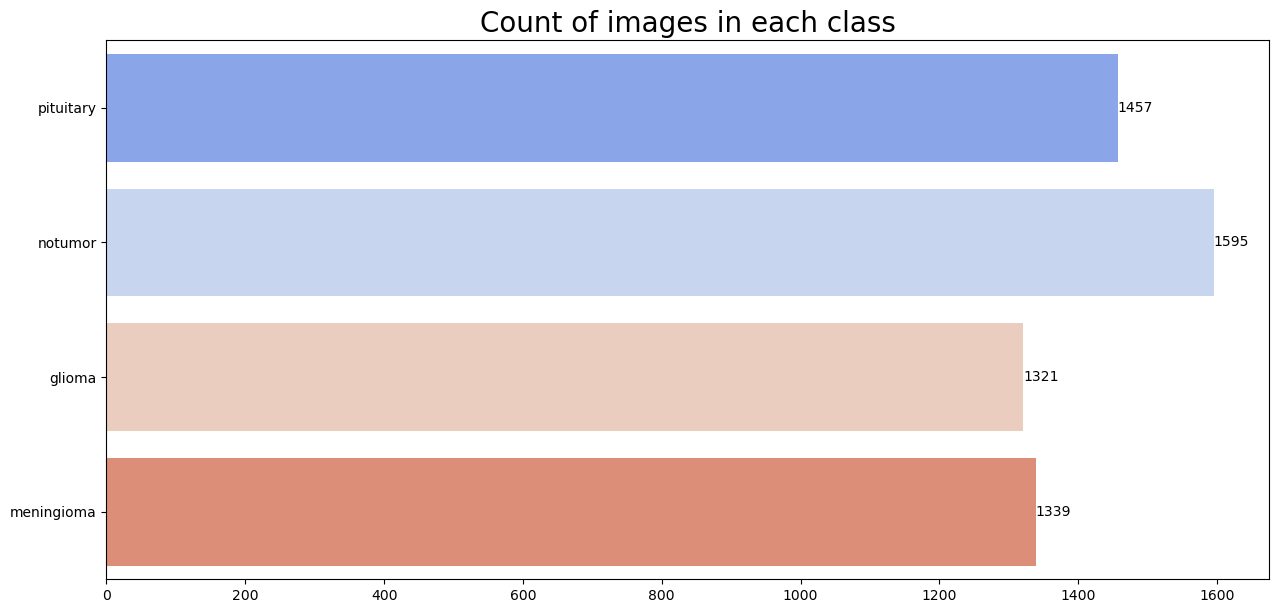

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train , y=train['Class'], palette='coolwarm')

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

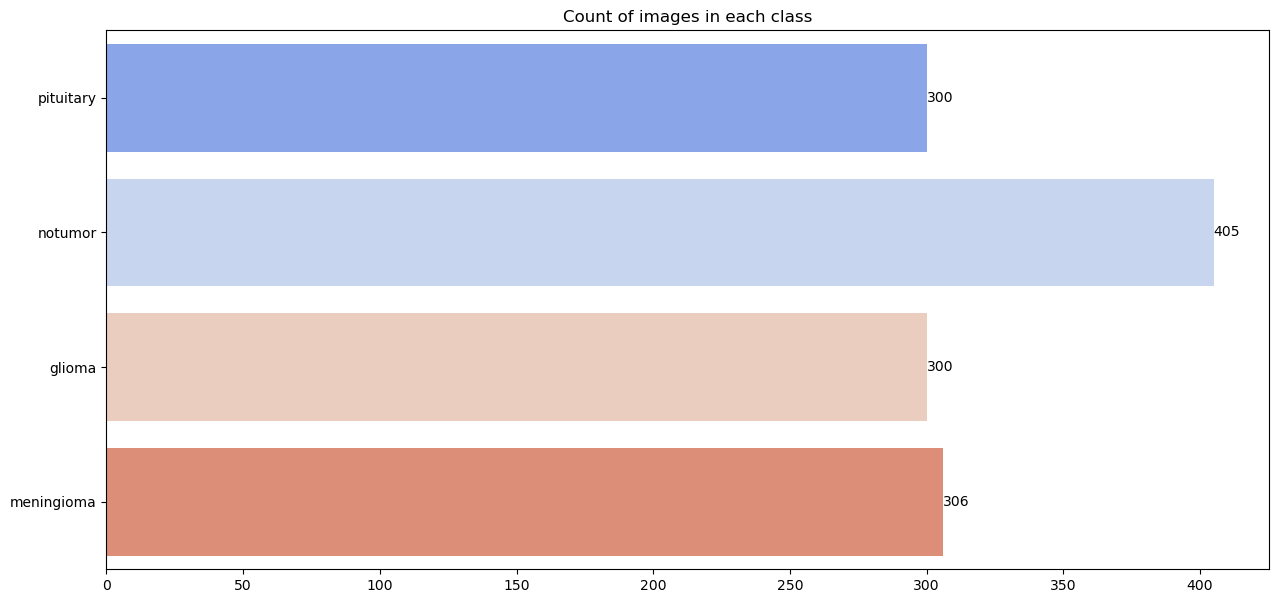

In [9]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=test['Class'], palette='coolwarm')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [10]:
from sklearn.model_selection import train_test_split
valid, test = train_test_split(test, train_size=0.5, random_state=20, stratify=test['Class'])

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
batch_size = 32
img_size = (256, 256)

generator = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))



training = generator.flow_from_dataframe(train, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

validation = generator.flow_from_dataframe(valid, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

testing = generator.flow_from_dataframe(test, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


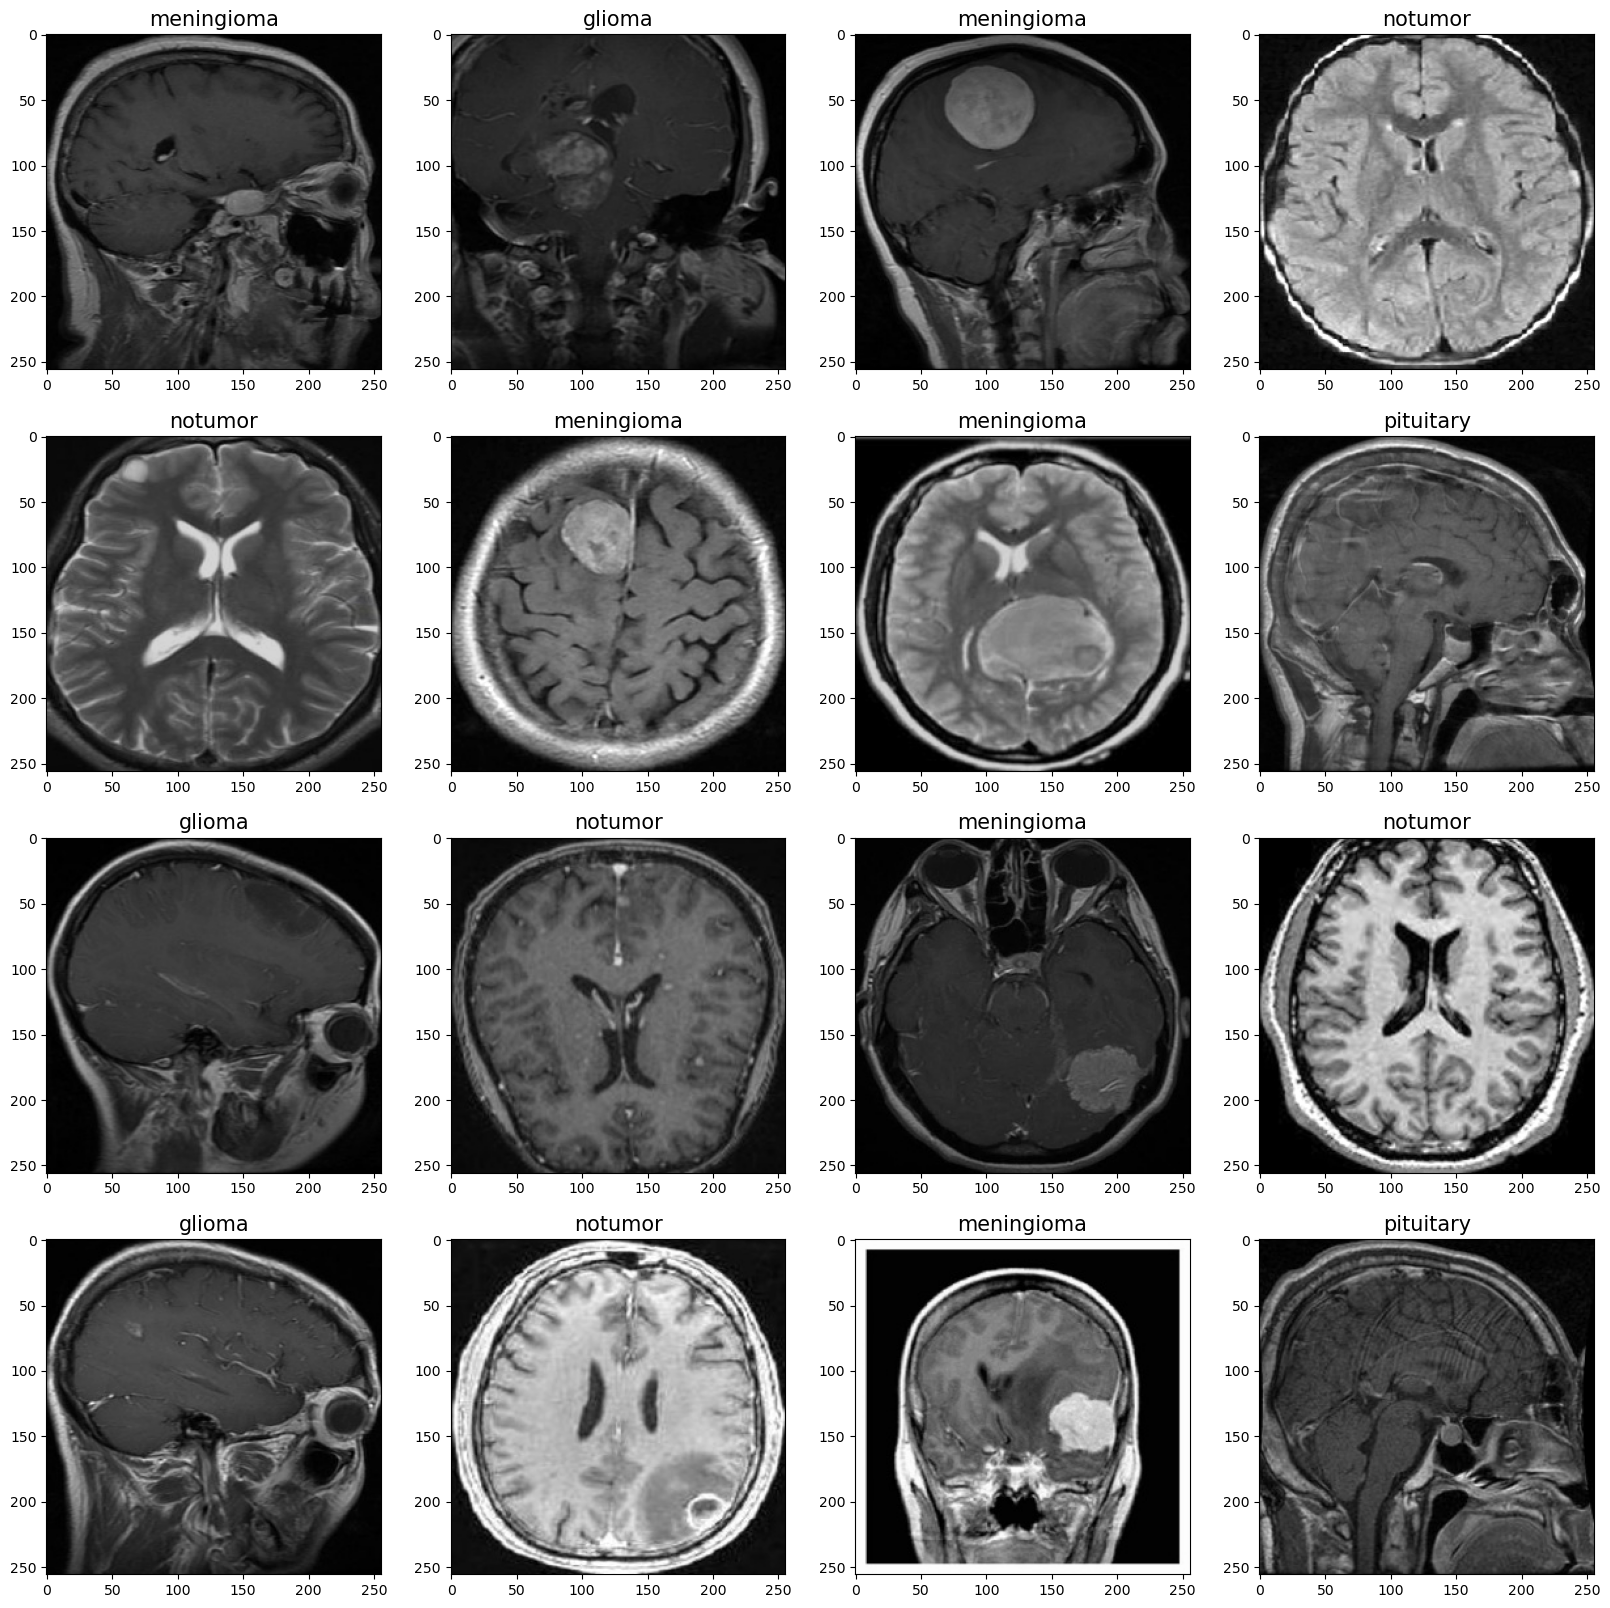

In [13]:
class_dict = training.class_indices
classes = list(class_dict.keys())
images, labels = next(testing)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [14]:
img_shape=(256,256,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
history = model.fit(training,
                 epochs=10,
                 validation_data=validation,
                 shuffle= False)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2826s 16s/step - accuracy: 0.7694 - loss: 0.6249 - precision: 0.8302 - recall: 0.6638 - val_accuracy: 0.9450 - val_loss: 0.1497 - val_precision: 0.9564 - val_recall: 0.9374
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3209s 18s/step - accuracy: 0.9772 - loss: 0.0706 - precision: 0.9789 - recall: 0.9759 - val_accuracy: 0.9191 - val_loss: 0.2354 - val_precision: 0.9338 - val_recall: 0.9038
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13554s 76s/step - accuracy: 0.9901 - loss: 0.0332 - precision: 0.9913 - recall: 0.9901 - val_accuracy: 0.9710 - val_loss: 0.0842 - val_precision: 0.9814 - val_recall: 0.9679
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4386s 25s/step - accuracy: 0.9923 - loss: 0.0266 - precision: 0.9928 - recall: 0.9922 - val_accuracy: 0.9664 - val_loss: 0.1216 - val_precision: 0.9679 - val_recall: 0.9664
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3168s 18s/step - accuracy: 0.9945 - loss: 0.0159 - precision: 0.9945 - recall: 0.9945 - val_accuracy: 0.983

In [17]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_per = history.history['precision']
train_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(train_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

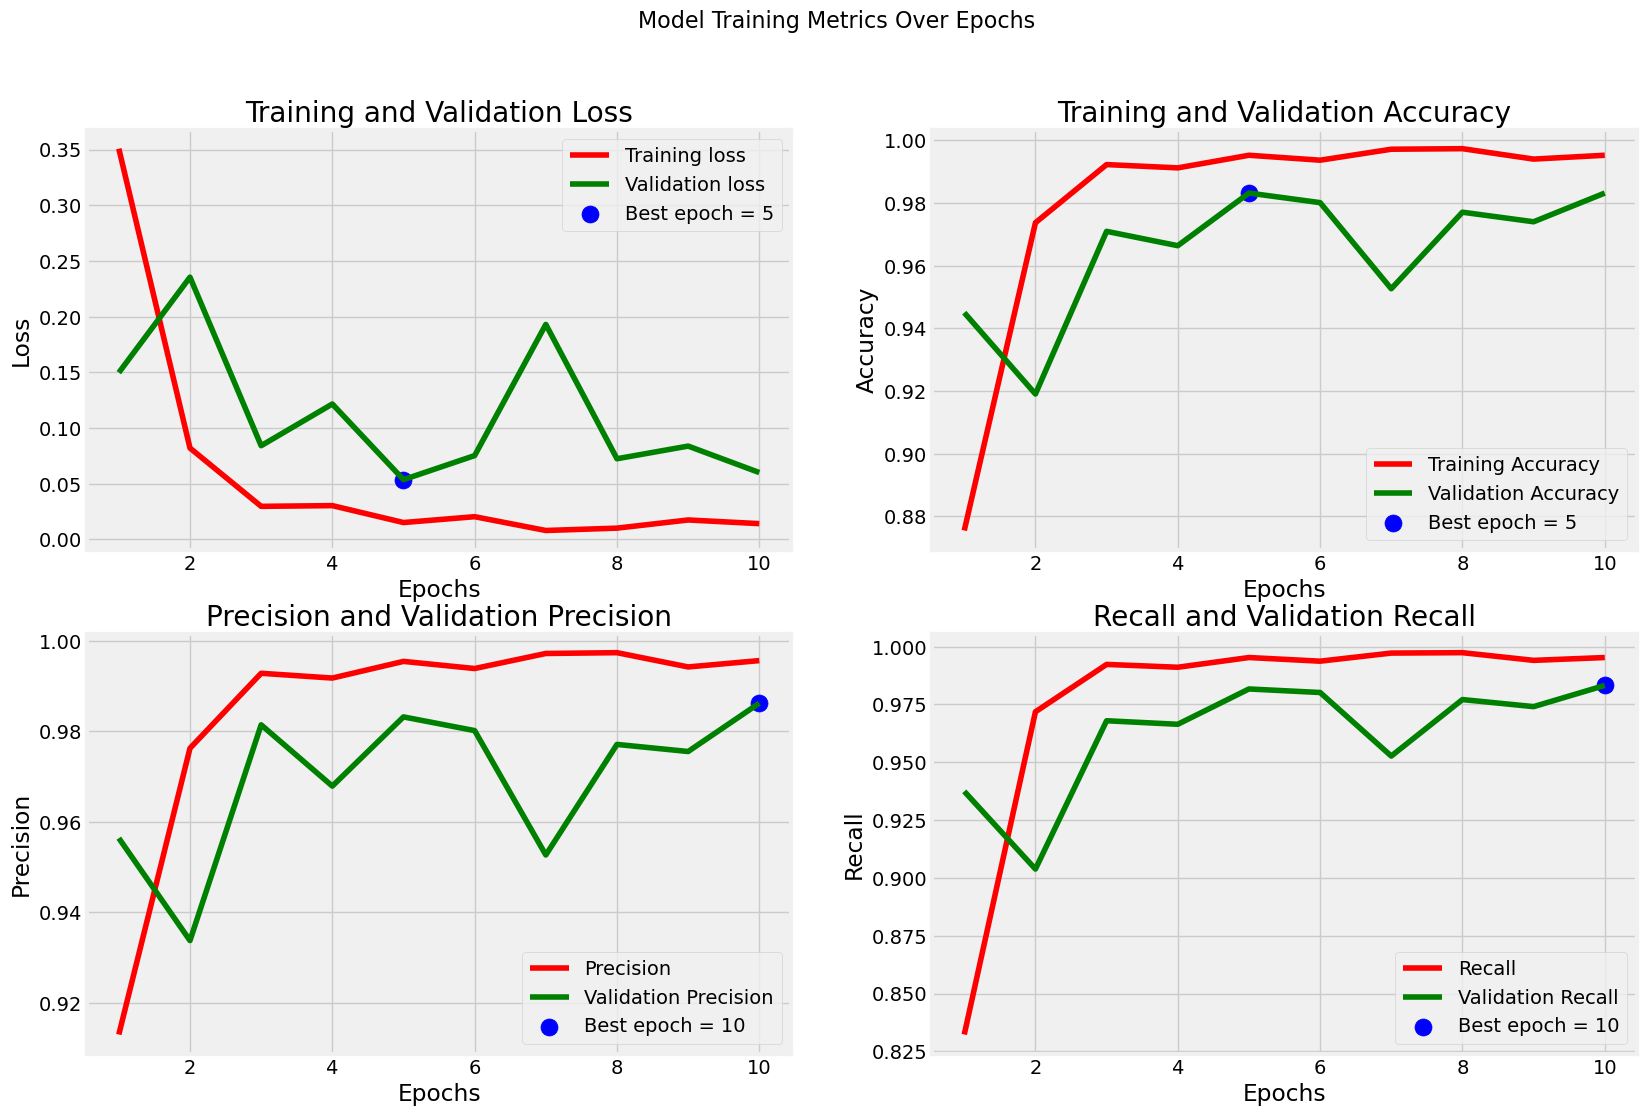

In [18]:
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, train_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, train_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [19]:
train_score = model.evaluate(training, verbose=1)
valid_score = model.evaluate(validation, verbose=1)
test_score = model.evaluate(testing, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9992 - loss: 0.0049 - precision: 0.9992 - recall: 0.9992
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9814 - loss: 0.0683 - precision: 0.9840 - recall: 0.9814


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9967 - loss: 0.0181 - precision: 0.9967 - recall: 0.9967
Train Loss: 0.0031
Train Accuracy: 99.93%
--------------------
Validation Loss: 0.0598
Validation Accuracy: 98.32%
--------------------
Test Loss: 0.0297
Test Accuracy: 99.39%


In [22]:
model.save("../Models/mri-brain-tumor-detector.keras")